In [3]:
import warnings
warnings.filterwarnings('ignore')
import xarray as xr
import numpy as np
import sys
import glob
import pandas as pd
from sklearn.linear_model import LinearRegression, TheilSenRegressor
import os
import time
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.font_manager
import warnings
warnings.filterwarnings('ignore')
import matplotlib.font_manager
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cross_decomposition import CCA
import matplotlib.gridspec as gridspec
from shapely.geometry import mapping
import ppca
from ppca import PPCA
import pymannkendall as mk
import cca_zoo
from cca_zoo.linear import MCCA
import scipy.stats as stats

start_time = time.time()

rc('font', **{'family': 'sans-serif', 'sans-serif': ['Arial']})
plt.rcParams.update({'font.size': 4})
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['lines.linewidth'] = 0.3
plt.rcParams['lines.markersize'] = 0.001


def data_path(filename):
    file_path = "{path}/{filename}".format(
        path="/Users/wantongli/Documents/GitHub/Syndrome-of-change",
        filename=filename
    )
    return file_path


def read_data(path):
    data = np.load(path)
    return data


def upscale_gridded_data(datacube):
    # variables
    atm_var_new = ['PET', 'ssrd', 'tp', 'rh',
           't2m', 't2m_min_min', 't2m_max_max', 't2m_min_mean', 't2m_max_mean', 'cloud', 'PEI_90']

    bio_var = ['albedo', 'albedo_times_ssrd',
               'ET_gleam', 'ET_era5', 'T_gleam',
               'sm', 'tws', 'ndwi',
               'ndvi', 'nirv', 'sif_gosif',
               'VOD_day','VOD_night','VOD_ratio',
                'LST_divide_t2m', 'lst_day', 'lst_night']
    
    # read shapefile
    shapefile = gpd.read_file(data_path("data/TM_WORLD_BORDERS-0.3/TM_WORLD_BORDERS-0.3.shp"))

    WDI_df_new = pd.read_csv(data_path('data/WDI_2003_2022_flaged_transpose.csv'))
 
    shapefile_new = shapefile[shapefile['ISO3'].isin(np.unique(WDI_df_new['Country Code']))].reset_index(drop=True)
    code_list = np.unique(shapefile_new['ISO3'])
    print(len(code_list))

    atm_data_subregion_all = pd.DataFrame()
    bio_data_subregion_all = pd.DataFrame()
    sio_data_subregion_all = pd.DataFrame()


    # read population data and tree cover data
    pop_orign = xr.open_dataset(data_path('data/gpw_v4_population_density_rev11_15_min.nc'))
    POP = np.nanmean(pop_orign['Population Density, v4.11 (2000, 2005, 2010, 2015, 2020): 15 arc-minutes'][0:4, ::-1, :], axis=0)  # the average of      2000, 2005, 2010, 2015
    POP = xr.DataArray(POP, dims=("lat", "lon"), coords=dict(lat=datacube.lat, lon=datacube.lon))

    for code in code_list: # loop across countries
        print(code)
        atm_bio = datacube.copy()
        atm_bio.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
        atm_bio.rio.write_crs("epsg:4326", inplace=True)
        region_shape = shapefile[shapefile['ISO3'].isin([code])]
        clipped = atm_bio.rio.clip(region_shape.geometry.apply(mapping), atm_bio.rio.crs, drop=True, all_touched=True)

        # weighted by POP
        pop = POP.copy()
        pop.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
        pop.rio.write_crs("epsg:4326", inplace=True)
        region_shape = shapefile[shapefile['ISO3'].isin([code])]
        clipped_pop = pop.rio.clip(region_shape.geometry.apply(mapping), pop.rio.crs, drop=True, all_touched=True)
        clipped_pop1 = (clipped_pop - np.nanmin(clipped_pop)) / (np.nanmax(clipped_pop) - np.nanmin(clipped_pop)) ### make pop from 0-1
        clipped = clipped * clipped_pop1

        atm_data_subregion = clipped[atm_var_new].mean(dim=("lat", "lon"), skipna=True)
        bio_data_subregion = clipped[bio_var].mean(dim=("lat", "lon"), skipna=True)
        atm_data_subregion['t2m_min_min'] = clipped['t2m_min_min'].min(dim=("lat", "lon"), skipna=True) # pick one extreme from clip don't need to weight by pop
        atm_data_subregion['t2m_max_max'] = clipped['t2m_max_max'].max(dim=("lat", "lon"), skipna=True) # pick one extreme from clip don't need to weight by pop

        atm_data_subregion = atm_data_subregion.to_dataframe().drop(columns=['spatial_ref']).reset_index()[atm_var_new]
        bio_data_subregion = bio_data_subregion.to_dataframe().drop(columns=['spatial_ref']).reset_index()[bio_var]

        atm_data_subregion['year'] = np.arange(2003, 2023, 1)
        atm_data_subregion['Country'] = code


        atm_data_subregion_all = atm_data_subregion_all._append(atm_data_subregion).reset_index()[atm_var_new]
        bio_data_subregion_all = bio_data_subregion_all._append(bio_data_subregion).reset_index()[bio_var]

    atm_data_subregion_all = atm_data_subregion_all.rename(columns=lambda x: x + '' if x in atm_var_new else x)
    bio_data_subregion_all = bio_data_subregion_all.rename(columns=lambda x: x + '' if x in bio_var else x)
    df_all = pd.concat([atm_data_subregion_all, bio_data_subregion_all, sio_data_subregion_all], axis=1)

    print('clipping done')
    return(df_all)




# Part 1: Aggregate gridded data to national scale


In [ ]:
# Read datacubes
ds_new1 = xr.open_zarr("/Users/wantongli/Documents/work/pstudy1_syndromes/programming/result/result122023/New_datacube_Jan.zarr").sel(
    time=slice('2003-01-05', '2022-12-26'))
ds_new2 = xr.open_zarr("/Users/wantongli/Documents/work/pstudy1_syndromes/programming/result/result122023/New_datacube_Jan13.zarr").sel(
    time=slice('2003-01-05', '2022-12-26'))

ds_2003_2022 = xr.merge([ds_new1, ds_new2])
ds_2003_2022.where(ds_2003_2022 == np.inf).fillna(np.nan)
ds_2003_2022.where(ds_2003_2022 == -np.inf).fillna(np.nan)

# weight by lat to accurate the land area
weights = np.zeros((720, 1440)) * np.nan
for lll in range(1440):
    weights[:, lll] = np.cos(np.deg2rad(ds_2003_2022.lat))

Weights = xr.DataArray(weights, dims=("lat", "lon"),coords=dict(lat=ds_2003_2022.lat, lon=ds_2003_2022.lon))

# different types of datacube
ds_2003_2022_annual = ds_2003_2022.resample(time="12MS").mean(dim="time") * Weights # note that here, high latitudes have weights 0-0.4, low                     latitudes have weights 0.4-1. all high latitude have smaller values after adding weights, but we do standarization before cca
ds_2003_2022_annual['t2m_min_min'] = ds_2003_2022['t2m_min'].resample(time="12MS").min(dim="time") * Weights
ds_2003_2022_annual['t2m_min_mean'] = ds_2003_2022['t2m_min'].resample(time="12MS").min(dim="time") * Weights # in the spatial aggragation function, use min instead of mean
ds_2003_2022_annual['t2m_max_max'] = ds_2003_2022['t2m_max'].resample(time="12MS").max(dim="time") * Weights
ds_2003_2022_annual['t2m_max_mean'] = ds_2003_2022['t2m_max'].resample(time="12MS").max(dim="time") * Weights # in the spatial aggragation function, use max instead of mean
# vod ration is between 0-1
vod_ratio_avg = ds_2003_2022_annual['VOD_ratio'].mean(dim='time')
ds_2003_2022_annual['VOD_ratio'] = ds_2003_2022_annual['VOD_ratio'].where((vod_ratio_avg >= 0) & (vod_ratio_avg <= 1), np.nan)

# aggregation
Df_all = upscale_gridded_data(ds_2003_2022_annual)
# Df_all.to_csv(data_path('result/result122023/df_all_annual_noweight_newDec2024.csv')) # without weight by population
# Df_all.to_csv(data_path('result/result122023/df_all_annual_weightbyPOP_newDec2024.csv')) # with weight by population

print("--- %s seconds ---" % (time.time() - start_time))

# Part 2: Gap fill world bank data

In [31]:
# Read the world bank data
WDI_df = pd.read_csv(data_path('data/WDI_2003_2022.csv'))

# change table format, transpose data series ###
flag = pd.read_csv(data_path('data/WDI_2003_2022_var_list.csv'))
new_var_list = flag['Series Code'][flag['flag']==1]
WDI_df = WDI_df.where(WDI_df['Series Code'].isin(new_var_list))

### old columns (years) --> new columns (variables)
column_list = ['Country Code']
column_list1 = []
for y in range(2003,2023,1):
    column_list.append(str(y) + ' [YR' + str(y) + ']')
    column_list1.append(str(y) + ' [YR' + str(y) + ']')

# create a new Dataframe subset
d=[]
v_list = WDI_df['Series Code'].unique().tolist()
for v in range(len(v_list)):
    d.append(v_list[v])
WDI_df_new = pd.DataFrame(columns=(d))

for var in WDI_df['Series Code'].unique():
    WDI_df_var = WDI_df[column_list][WDI_df['Series Code']==var].copy()
    WDI_df_var = pd.melt(WDI_df_var, id_vars=['Country Code'], value_vars=column_list1)
    WDI_df_new['Country Code'] = WDI_df_var['Country Code']
    WDI_df_new['year'] = WDI_df_var['variable']
    WDI_df_new[var] = WDI_df_var['value']

# WDI_df_new.to_csv(data_path('data/WDI_2003_2022_flaged_transpose.csv'))

,EG.CFT.ACCS.ZS,EG.CFT.ACCS.RU.ZS,EG.CFT.ACCS.UR.ZS,EG.ELC.ACCS.ZS,EG.ELC.ACCS.RU.ZS,EG.ELC.ACCS.UR.ZS,FX.OWN.TOTL.ZS,FX.OWN.TOTL.FE.ZS,FX.OWN.TOTL.MA.ZS,FX.OWN.TOTL.OL.ZS,...,SG.VAW.ARGU.ZS,SG.VAW.BURN.ZS,SG.VAW.GOES.ZS,SG.VAW.NEGL.ZS,SG.VAW.REFU.ZS,SP.M15.2024.FE.ZS,SP.M18.2024.FE.ZS,SH.DYN.AIDS.FE.ZS,Country Code,year
0,10.0,1.9,43.2,18.971165,2.130410,77.470428,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.9,AFG,2003
1,46.5,24.8,73.6,99.385628,100.000000,96.816048,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.3,ALB,2003
2,97.9,95.1,99.9,98.615211,97.415244,99.341850,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.1,DZA,2003
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ASM,2003
4,100.0,100.0,100.0,100.000000,100.000000,100.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AND,2003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4335,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VIR,2022
4336,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PSE,2022
4337,NaN,NaN,NaN,NaN,NaN,NaN,11.9,5.44,18.35,16.13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,YEM,2022
4338,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ZMB,2022


In [28]:
# transpose table format to distinguish countries ###
WDI_df_new = pd.read_csv(data_path('data/WDI_2003_2022.csv'))
flag = pd.read_csv(data_path('data/WDI_2003_2022_var_list.csv'))
new_var_list = flag['Series Code'][flag['flag']==1]
WDI_df_new = WDI_df_new.where(WDI_df_new['Series Code'].isin(new_var_list))

### old columns (years) --> new columns (variables)
column_list = ['Series Code']
column_list1 = []
for y in range(2003,2023,1):
    column_list.append(str(y) + ' [YR' + str(y) + ']')
    column_list1.append(str(y) + ' [YR' + str(y) + ']')

# create a new Dataframe subset
d=[]
v_list = WDI_df_new['Country Code'].unique().tolist()
for v in range(len(v_list)):
    d.append(v_list[v])
WDI_df_new_new = pd.DataFrame(columns=(d))

for var in WDI_df['Country Code'].unique():
    WDI_df_var = WDI_df_new[column_list][WDI_df_new['Country Code']==var].copy()
    WDI_df_var = pd.melt(WDI_df_var, id_vars=['Series Code'], value_vars=column_list1)
    WDI_df_new_new['Series Code'] = WDI_df_var['Series Code']
    WDI_df_new_new['year'] = WDI_df_var['variable']
    WDI_df_new_new[var] = WDI_df_var['value']

WDI_df_new_new
# WDI_df_new_new.to_csv(data_path('data/WDI_2003_2022_flaged_transpose_country.csv'))

,AFG,NaN,ALB,DZA,ASM,AND,AGO,ATG,ARG,ARM,...,VUT,VEN,VNM,VIR,PSE,YEM,ZMB,ZWE,Series Code,year
0,10.000000,NaN,46.500000,97.900000,NaN,100.0,41.500000,100.00000,97.200000,87.400000,...,15.300000,97.200000,22.100000,NaN,NaN,57.000000,15.100000,33.000000,EG.CFT.ACCS.ZS,2003 [YR2003]
1,1.900000,NaN,24.800000,95.100000,NaN,100.0,7.200000,100.00000,82.200000,71.800000,...,4.000000,77.500000,9.500000,NaN,NaN,43.200000,1.700000,4.700000,EG.CFT.ACCS.RU.ZS,2003 [YR2003]
2,43.200000,NaN,73.600000,99.900000,NaN,100.0,79.100000,100.00000,98.900000,96.600000,...,54.800000,99.400000,55.500000,NaN,NaN,93.900000,39.700000,85.700000,EG.CFT.ACCS.UR.ZS,2003 [YR2003]
3,18.971165,NaN,99.385628,98.615211,NaN,100.0,27.355137,97.87252,96.297951,99.106911,...,27.478312,95.700000,90.270866,100.0,99.10000,52.595875,18.500000,35.135029,EG.ELC.ACCS.ZS,2003 [YR2003]
4,2.130410,NaN,100.000000,97.415244,NaN,100.0,2.255916,96.96587,92.904366,98.903242,...,12.257175,67.284785,87.146768,100.0,97.50806,37.391822,1.941511,8.777362,EG.ELC.ACCS.RU.ZS,2003 [YR2003]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20835,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SG.VAW.NEGL.ZS,2022 [YR2022]
20836,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SG.VAW.REFU.ZS,2022 [YR2022]
20837,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SP.M15.2024.FE.ZS,2022 [YR2022]
20838,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SP.M18.2024.FE.ZS,2022 [YR2022]


# Now it starts gapfilling

In [32]:
WDI_df_new = pd.read_csv(data_path('data/WDI_2003_2022_flaged_transpose.csv'))
# Check if 'year' in WDI_df_new is numeric; if not, convert to int
if WDI_df_new['year'].dtype == object:
    # If 'year' is stored as a string with '[YR2003]' format, extract the numeric part
    WDI_df_new['year'] = WDI_df_new['year'].str.extract(r'(\d{4})').astype(int)
else:
    # If 'year' is already numeric, convert it to int
    WDI_df_new['year'] = WDI_df_new['year'].astype(int)
    
WDI_df_new_country = pd.read_csv(data_path('data/WDI_2003_2022_flaged_transpose_country.csv'))
WDI_df_new_country = WDI_df_new_country.drop(columns=['Series Code', 'year'])

#### Remove countries or variables with too much gaps ###
WDI_df_new_country_list = WDI_df_new_country.loc[:, WDI_df_new_country.isnull().mean() < .7].columns # i used default 0.7
WDI_df_new = WDI_df_new[WDI_df_new['Country Code'].isin(WDI_df_new_country_list)]

WDI_df_new_var_list = WDI_df_new.loc[:, WDI_df_new.isnull().mean() < .7].columns # i used default 0.7
WDI_df_new = WDI_df_new[WDI_df_new_var_list]
WDI_df_new

,Unnamed: 0,EG.CFT.ACCS.ZS,EG.CFT.ACCS.RU.ZS,EG.CFT.ACCS.UR.ZS,EG.ELC.ACCS.ZS,EG.ELC.ACCS.RU.ZS,EG.ELC.ACCS.UR.ZS,SE.PRM.TENR,SE.PRM.TENR.FE,SE.PRM.TENR.MA,...,SL.EMP.VULN.MA.ZS,SL.EMP.VULN.ZS,SL.EMP.WORK.FE.ZS,SL.EMP.WORK.MA.ZS,SL.EMP.WORK.ZS,ER.GDP.FWTL.M3.KD,SG.LAW.INDX,SH.DYN.AIDS.FE.ZS,Country Code,year
0,0,10.0,1.9,43.2,18.971165,2.130410,77.470428,NaN,NaN,NaN,...,90.373290,91.581280,1.612625,9.141744,8.000525,0.405408,26.250,27.9,AFG,2003
1,1,46.5,24.8,73.6,99.385628,100.000000,96.816048,91.69871,92.23154,91.20947,...,56.673010,57.382960,40.642190,37.995090,39.080410,4.592167,77.500,24.3,ALB,2003
2,2,97.9,95.1,99.9,98.615211,97.415244,99.341850,94.35822,93.23500,95.43476,...,28.570412,29.075119,66.137170,64.774320,64.972020,18.103639,40.625,43.1,DZA,2003
5,5,41.5,7.2,79.1,27.355137,2.255916,49.043541,NaN,NaN,NaN,...,45.085643,59.963071,22.507650,49.340050,35.985370,54.158232,62.500,62.9,AGO,2003
6,6,100.0,100.0,100.0,97.872520,96.965870,99.941978,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,235.415430,66.250,NaN,ATG,2003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4334,4334,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,88.125,NaN,VNM,2022
4336,4336,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,26.250,NaN,PSE,2022
4337,4337,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,26.875,NaN,YEM,2022
4338,4338,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,81.250,NaN,ZMB,2022


# Test the explained variance of ppca

(3760, 749)
[0.27345775 0.34065101 0.38983389 0.43118339 0.46653586 0.49276894
 0.51640081 0.5382657  0.55752426 0.57482918 0.59085039 0.60556062
 0.61847379 0.63130443 0.64355707 0.65509938 0.66620949 0.67617073
 0.68579992 0.69505868 0.70396947 0.71206573 0.71977891 0.72702758
 0.73380727 0.74029926 0.74661778 0.75271682 0.7585348  0.76431556
 0.76969717 0.77488056 0.77997438 0.78484487 0.7896873  0.79431845
 0.79868152 0.80299385 0.80701049 0.81094069 0.81472207 0.81843337
 0.82212679 0.82562199 0.82907461 0.83240435 0.83564893 0.83882942
 0.84187235 0.84483337 0.84771402 0.85053744 0.85324741 0.85586851
 0.85845945 0.86095178 0.86338972 0.86571315 0.86798183 0.87011274
 0.87221178 0.87425785 0.87625118 0.87819703 0.88007168 0.88192358
 0.8837419  0.88548461 0.88721457 0.8888644  0.89048742 0.89206261
 0.89361736 0.89514788 0.89666845 0.8980958  0.89950591 0.90090729
 0.90226037 0.90359335 0.90489808 0.90617595 0.90741329 0.90864364
 0.90981584 0.91097368 0.9121141  0.91323718 0.914

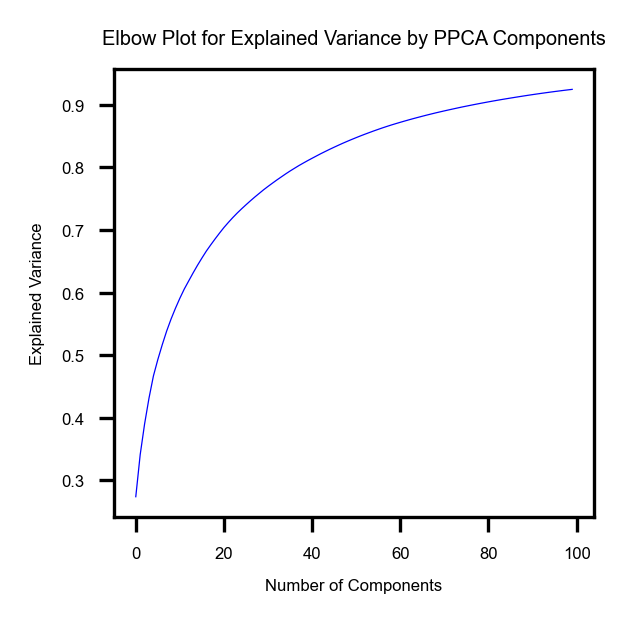

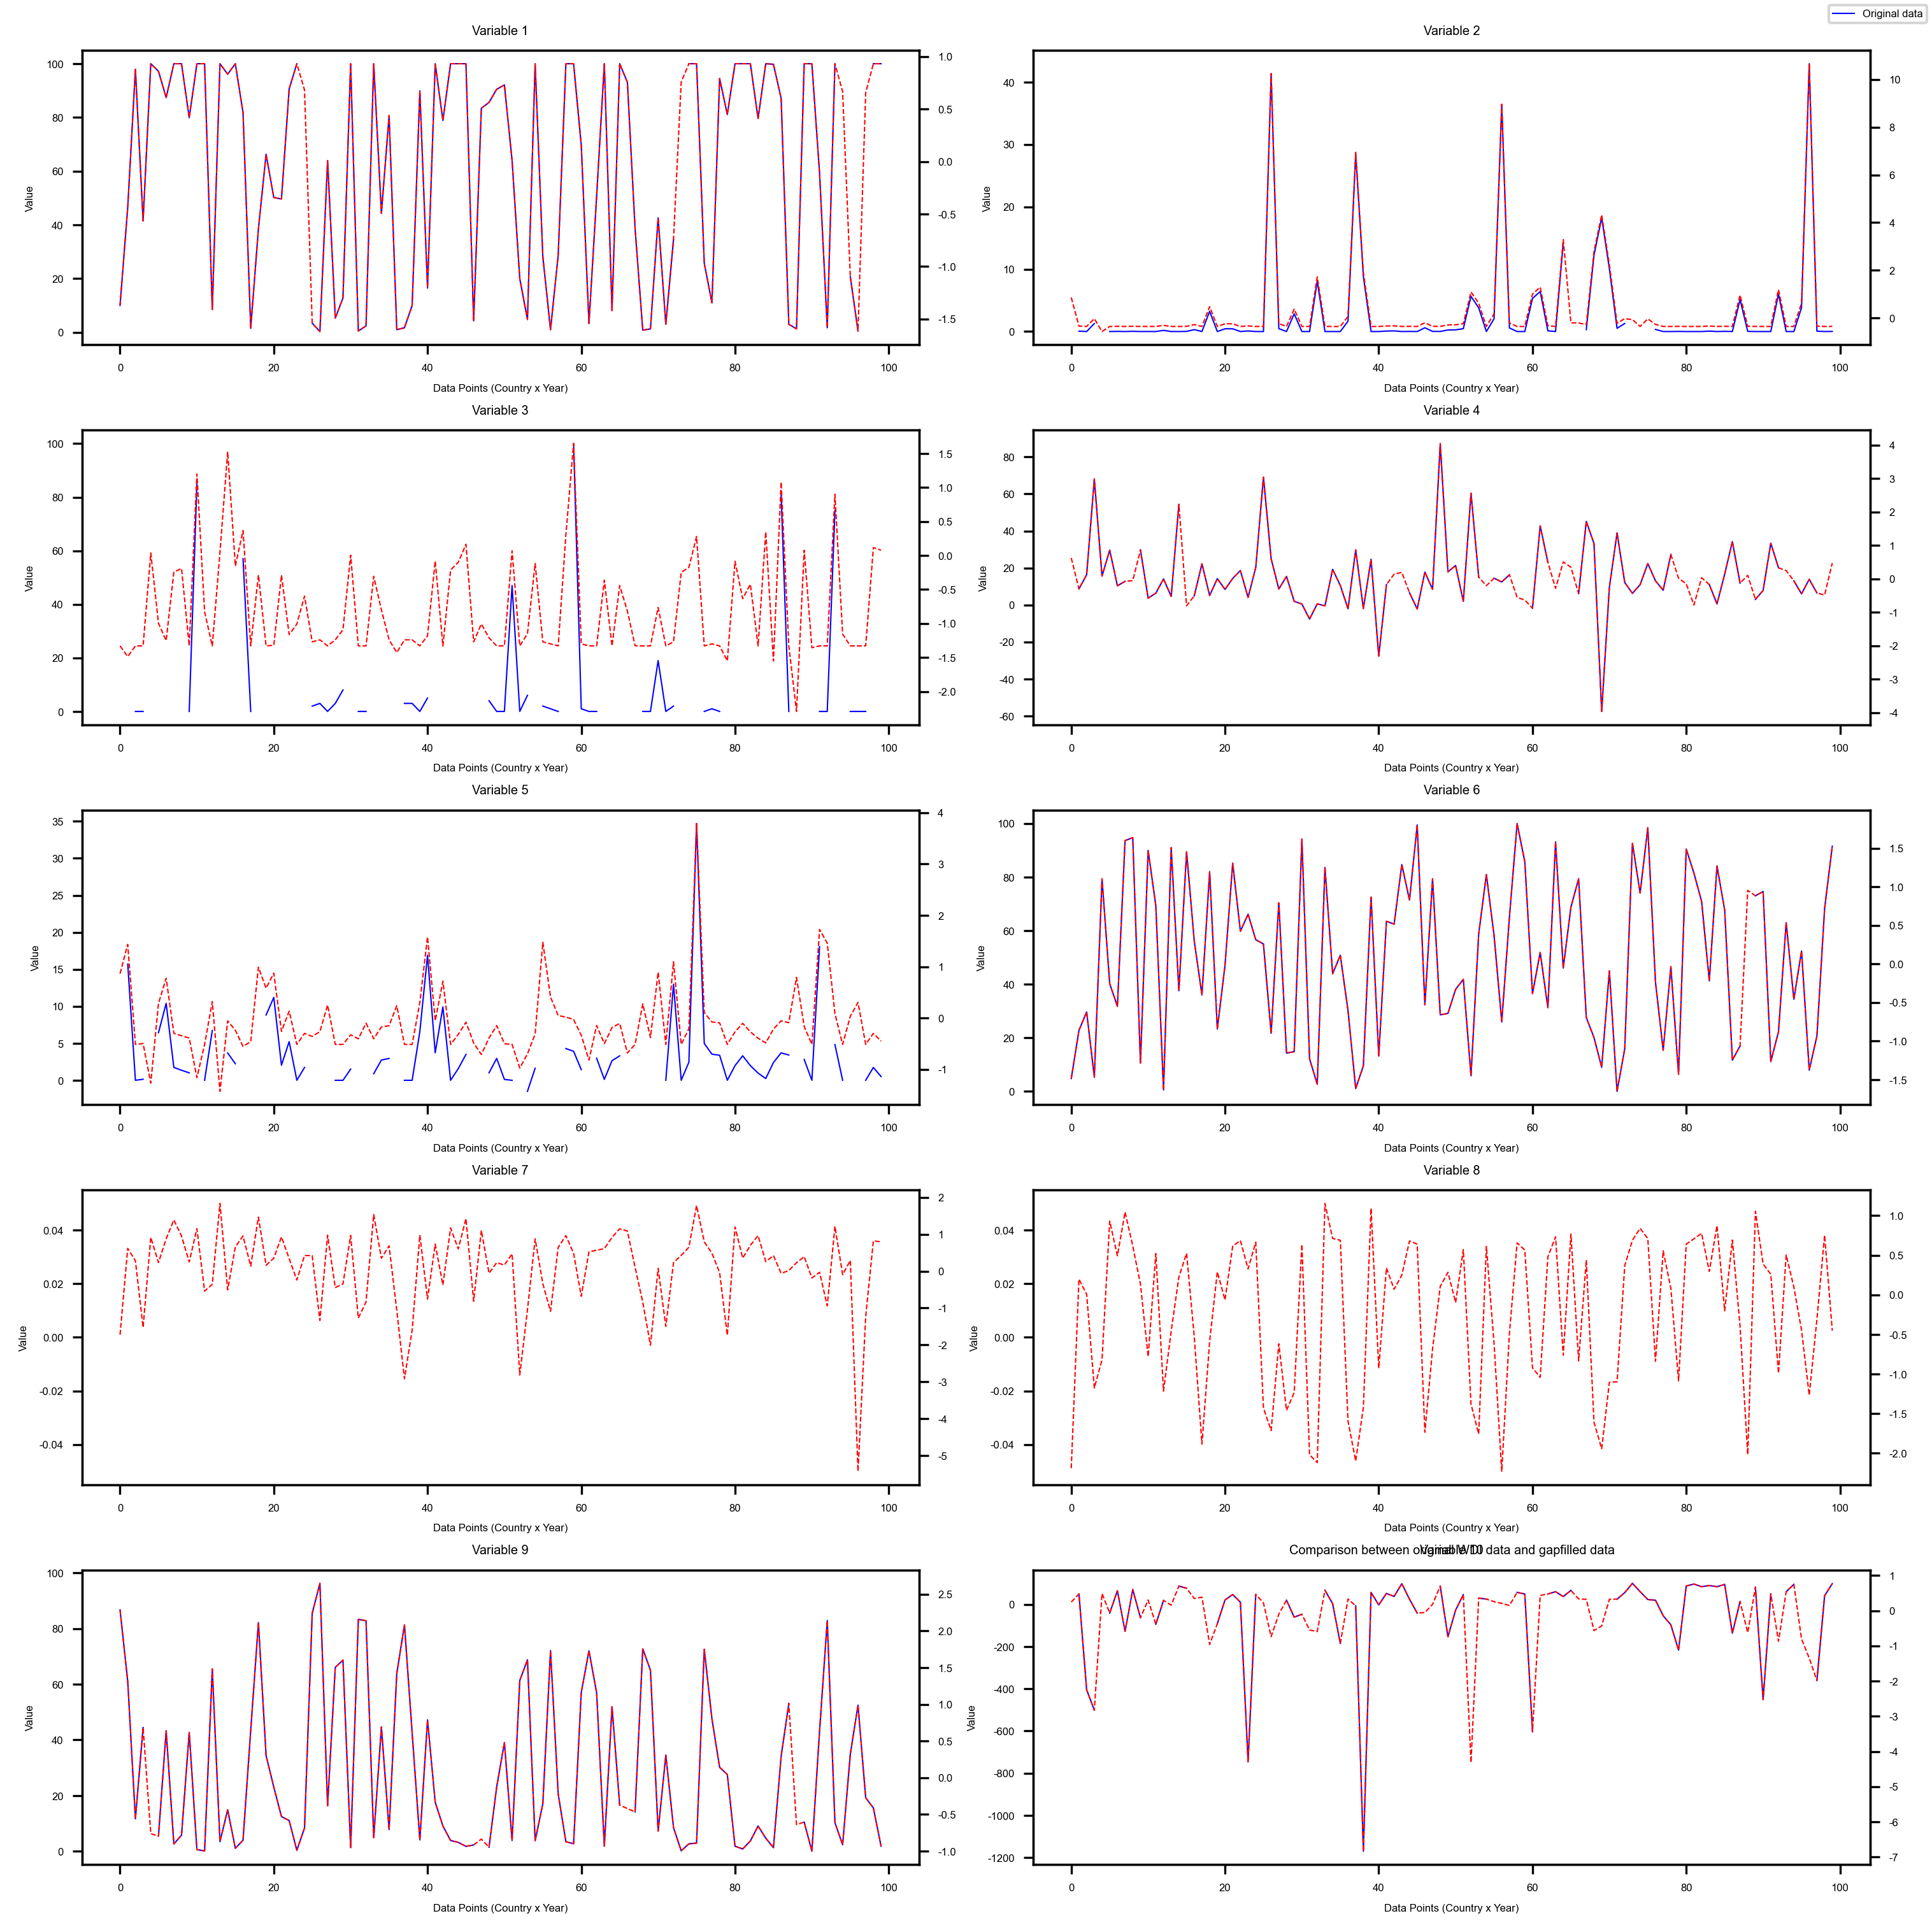

In [38]:
samples = WDI_df_new.drop(columns=['Unnamed: 0','Country Code','year']).reset_index(drop=True).to_numpy()
print(np.shape(samples))

ppca = PPCA()
ppca.fit(samples, 100)
variance_explained = ppca.var_exp
sample_gapfilled = ppca.data
print(variance_explained)

# Plot the elbow plot
fig = plt.figure(figsize=(2, 2), dpi=300, tight_layout=True)
plt.plot(list(range(len(variance_explained))), variance_explained, marker='o', linestyle='-', color='b')
plt.title('Elbow Plot for Explained Variance by PPCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')

# Create figure with 10 subplots (2 columns and 5 rows)
fig, axes = plt.subplots(5, 2, figsize=(10, 10), dpi=300, tight_layout=True)

# Loop over the first 10 variables (columns)
for i,v in zip(range(10), range(0,700,20)):
    # Select the subplot location
    ax = axes[(i // 2, i % 2)]  # Convert i to row and column indices

    # Plot original data (first 100 rows for simplicity)
    ax.plot(samples[0:100, v], linestyle='-', color='blue', linewidth=0.5, label='Original data')

    # Plot gap-filled data on the same plot
    ax1 = ax.twinx()
    ax1.plot(sample_gapfilled[0:100, v], linestyle='--', color='red', linewidth=0.5, label='Gap-filled data')

    # Set title and labels
    ax.set_title(f'Variable {i + 1}')
    ax.set_xlabel('Data Points (Country x Year)')
    ax.set_ylabel('Value')

# Add a global legend for the figure
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
plt.title('Comparison between original WDI data and gapfilled data')

# Show the plot
plt.tight_layout()
plt.show()

# Output gap-filled socioeconomic data

In [ ]:
# Drop 'Country Code' and 'year' to get the variable names from WDI_df_new
variable_names = WDI_df_new.drop(columns=['Unnamed: 0','Country Code', 'year']).columns

# Convert ppca.data (numpy array) to a DataFrame, using the original variable names
ppca_df = pd.DataFrame(ppca.data, columns=variable_names)

# Add the 'Country Code' and 'Year' columns from the original dataset
ppca_df['Country Code'] = WDI_df_new['Country Code'].values
ppca_df['year'] = WDI_df_new['year'].values

# Reorder the columns so that 'Country Code' and 'Year' come first
cols = ['Country Code', 'year'] + list(variable_names)
ppca_df = ppca_df[cols]
# ppca_df.to_csv(data_path('data/WDI_2003_2022_gapfilled_mask0.7.csv'), index=False)

# Part 3: Detrend and remove country-level means to lessen potential spurious correlation in the analysis of CCA

In [8]:
###### set variable names
bio_var1 = ['albedo', 'albedo_times_ssrd',
           # 'ET_gleam', 'ET_era5',
           'sm', 'tws', 'ndwi',
           'LST_divide_t2m',
           'ndvi', 'nirv', 'sif_gosif',
           'VOD_day','VOD_night','VOD_ratio']
atm_var1 = ['PET', 'ssrd', 'tp', 'rh', 't2m', 't2m_min_min', 't2m_max_max', 't2m_min_mean', 't2m_max_mean', 'cloud', 'PEI_90']

bio_var = []
atm_var = []
column_name = ['','_weightedbyPOP']
for multi_var in range(len(column_name)):
    bio_var.append([s + column_name[multi_var] for s in bio_var1])
    atm_var.append([s + column_name[multi_var] for s in atm_var1])
bio_var = [item for sublist in bio_var for item in sublist]
atm_var = [item for sublist in atm_var for item in sublist]
atm_var = [item for item in atm_var if item not in ['t2m_min_min_weightedbyPOP', 't2m_max_max_weightedbyPOP']]

sio_gapfilled = pd.read_csv(data_path('data/WDI_2003_2022_gapfilled_mask0.7.csv'))
sio_var = sio_gapfilled.drop(columns=['Country Code','year']).columns.values.tolist()

### read country-level data and minus means
df_bio_atm_sio1 = pd.read_csv(data_path('data/df_all_annual_noweight_newDec2024.csv'))
df_bio_atm_sio1 = df_bio_atm_sio1.drop(columns=['Unnamed: 0'])
df_bio_atm_sio2 = pd.read_csv(data_path('data/df_all_annual_weightbyPOP_newDec2024.csv'))
df_bio_atm_sio2 = df_bio_atm_sio2.drop(columns=['Unnamed: 0','year','Country Code'])
df_bio_atm_sio2.columns = [str(col) + '_weightedbyPOP' for col in df_bio_atm_sio2.columns]

### fit interpolate with linear method
df_bio_atm_sio = pd.concat([df_bio_atm_sio1, df_bio_atm_sio2], axis=1)
df_bio_atm_sio.replace([np.inf, -np.inf], np.nan, inplace=True)
# Apply interpolation for numeric columns only
df_numeric = df_bio_atm_sio.select_dtypes(include=[np.number])
df_numeric = df_numeric.interpolate(method='linear', limit_direction='both')
df_numeric = df_numeric.fillna(method='ffill').fillna(method='bfill')
df_bio_atm_sio.update(df_numeric)

df_bio_atm = df_bio_atm_sio[bio_var+atm_var+['year','Country Code']]

# Get the intersection of 'Country Code' values from both DataFrames
common_countries = np.intersect1d(df_bio_atm['Country Code'].unique(), sio_gapfilled['Country Code'].unique())

# Filter the DataFrame to include only rows where 'Country Code' is in the intersection
df_bio_atm_filtered = df_bio_atm[df_bio_atm['Country Code'].isin(common_countries)]
sio_gapfilled_filtered = sio_gapfilled[sio_gapfilled['Country Code'].isin(common_countries)]

# Merge on 'Country Code' and 'year'
df_bio_atm_filtered['year'] = df_bio_atm_filtered['year'].astype(int)
sio_gapfilled_filtered['year'] = sio_gapfilled_filtered['year'].astype(int)
merged_df = pd.merge(df_bio_atm_filtered, sio_gapfilled_filtered, on=['Country Code', 'year'], how='inner')


# Get the intersection of 'Country Code' values from both DataFrames
common_countries = np.intersect1d(df_bio_atm['Country Code'].unique(), sio_gapfilled['Country Code'].unique())

# Filter the DataFrame to include only rows where 'Country Code' is in the intersection
df_bio_atm_filtered = df_bio_atm[df_bio_atm['Country Code'].isin(common_countries)]
sio_gapfilled_filtered = sio_gapfilled[sio_gapfilled['Country Code'].isin(common_countries)]

# Merge on 'Country Code' and 'year'
df_bio_atm_filtered['year'] = df_bio_atm_filtered['year'].astype(int)
sio_gapfilled_filtered['year'] = sio_gapfilled_filtered['year'].astype(int)
merged_df = pd.merge(df_bio_atm_filtered, sio_gapfilled_filtered, on=['Country Code', 'year'], how='inner')

merged_df
# merged_df.to_csv(data_path('data/df_all_annual_normal_global.csv'))


# Plot a case

t2m : Mann_Kendall_Test(trend='increasing', h=True, p=0.040954544320382924, z=2.043989906247608, Tau=0.3368421052631579, s=64.0, var_s=950.0, slope=0.02793002858529601, intercept=-0.27827193619931084)
AG.LND.AGRI.ZS : Mann_Kendall_Test(trend='decreasing', h=True, p=0.001498002030616119, z=-3.175070302933689, Tau=-0.5157894736842106, s=-98.0, var_s=933.3333333333334, slope=-0.0023370349986202438, intercept=0.017218806088065565)


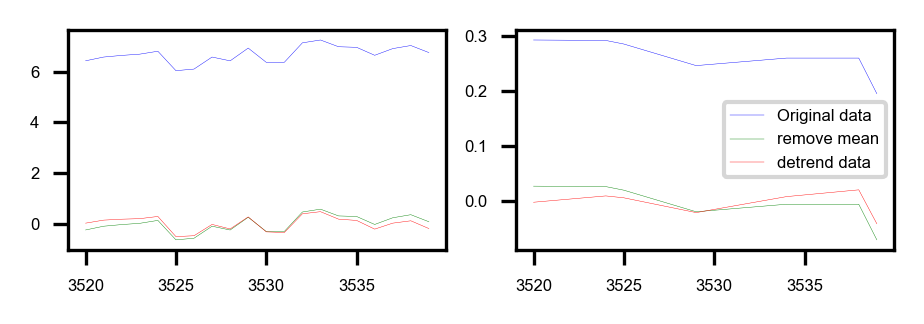

In [9]:
###### ### ### ###  detrend and remove means ### ### ### ### ### ### 
merged_df = pd.read_csv(data_path('data/df_all_annual_normal_global.csv'))

fig, axes = plt.subplots(1, 2, figsize=(3, 1), dpi=300, tight_layout=True)
for v, var in enumerate(['t2m','AG.LND.AGRI.ZS']):
    for i, category in enumerate(['USA']):
        org_data = merged_df[var].loc[merged_df['Country Code'] == category]
        org_data = pd.to_numeric(org_data, errors='coerce')
        # remove mean
        mean = org_data.mean()
        remove_mean = org_data - mean
            
        # Perform Mann-Kendall trend test
        result = mk.original_test(remove_mean.dropna())  # Drop NaN for the test
        print(var, ':', result)

        # If the trend is significant (p-value < 0.05), perform detrending
        if result.p < 0.05:
            y = remove_mean.values
            if np.isnan(y).any():
                detrended = np.nan
            else:
                X = np.arange(len(remove_mean)).reshape(-1, 1)
                model = LinearRegression()
                model.fit(X, y)
                trend = model.predict(X)
                detrended = remove_mean - trend
            # Update the original DataFrame with detrended values
            merged_df.loc[merged_df['Country Code'] == category, var] = detrended
        else:
            merged_df.loc[merged_df['Country Code'] == category, var] = remove_mean

        ### plot
        axes[v].plot(org_data, linestyle='-', color='blue', linewidth=0.1, label='Original data')
        axes[v].plot(remove_mean, linestyle='-', color='green', linewidth=0.1, label='remove mean')
        axes[v].plot(merged_df.loc[merged_df['Country Code'] == category, var], linestyle='-', color='red', linewidth=0.1, label='detrend data')
plt.legend()        
plt.show()

# Output full results


In [10]:
for v, var in enumerate(merged_df.columns.drop('year').drop('Country Code')):
    for i, category in enumerate(np.unique(merged_df['Country Code'])):
        org_data = merged_df[var].loc[merged_df['Country Code'] == category]
        org_data = pd.to_numeric(org_data, errors='coerce')
        # remove mean
        mean = org_data.mean()
        remove_mean = org_data - mean
        
        # merged_df.loc[merged_df['Country Code'] == category, var] = remove_mean
        
        # Perform Mann-Kendall trend test
        result = mk.original_test(remove_mean.dropna())  # Drop NaN for the test

        # If the trend is significant (p-value < 0.05), perform detrending
        if result.p < 0.05:
            # print(f"Significant trend found for {var} in {category}, detrending...")

            y = remove_mean.values
            if np.isnan(y).any():
                detrended = np.nan
            else:
                X = np.arange(len(remove_mean)).reshape(-1, 1)
                model = LinearRegression()
                model.fit(X, y)
                trend = model.predict(X)
                detrended = remove_mean - trend

            # Update the original DataFrame with detrended values
            merged_df.loc[merged_df['Country Code'] == category, var] = detrended
        else:
            merged_df.loc[merged_df['Country Code'] == category, var] = remove_mean

merged_df
# merged_df.to_csv(data_path('data/df_all_annual_normal_MinusSpatialMean_MinusMKTrend_global.csv'))

# Plot explained variance using detrended data and PCA

187
(3740, 795)
Explained variance:  [0.16509777 0.10131906 0.07792448 0.06177408 0.06076831 0.05680229
 0.05520238 0.04768592 0.0458204  0.04252757 0.04062154 0.03805262
 0.03641621 0.02763573 0.02434973 0.02352629 0.01780704 0.01666009] [0.27440567 0.14442932 0.11271541 0.07282845 0.06769665 0.05836502
 0.04823525 0.04712151 0.03179728 0.02379614 0.02070337 0.01771244
 0.01508875 0.01429805 0.01329638 0.01198301 0.00951441 0.007288  ] [0.0417663  0.03314736 0.02817852 0.02429932 0.02396141 0.02078691
 0.01955417 0.01695728 0.01635278 0.01590863 0.01506998 0.01378236
 0.01331446 0.01233511 0.0115527  0.01104892 0.01037978 0.00992897]


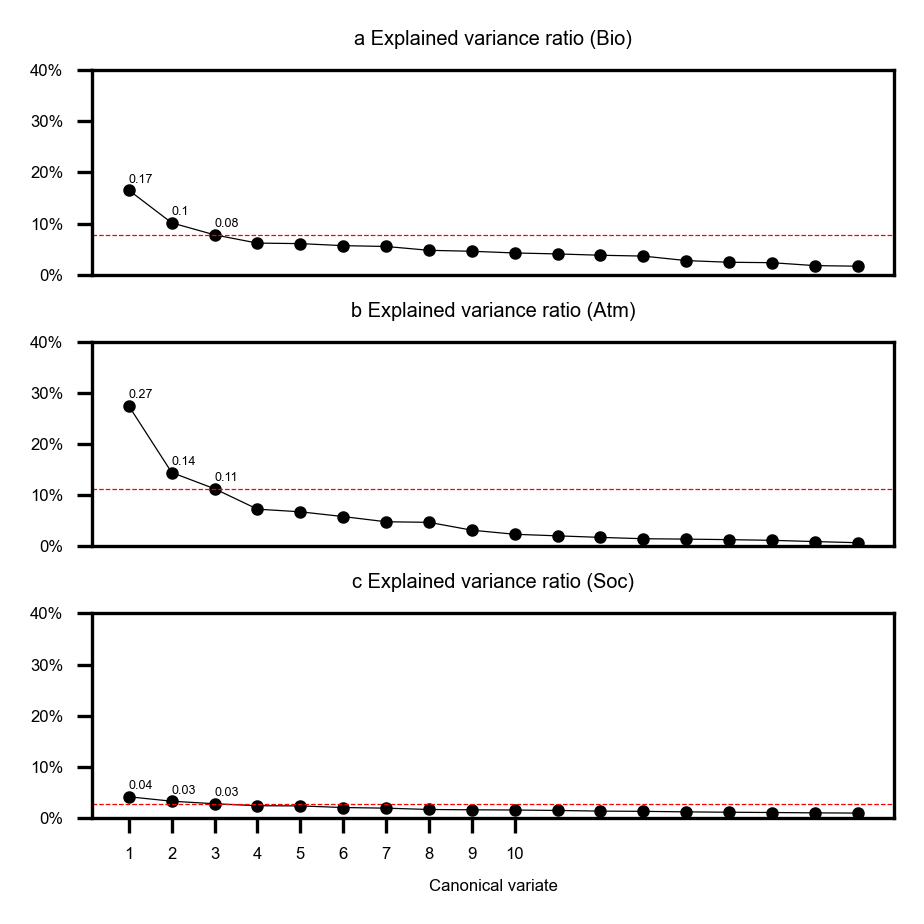

In [11]:
###### set variable names
bio_var1 = ['albedo', 'albedo_times_ssrd',
           # 'ET_gleam', 'ET_era5',
           'sm', 'tws', 'ndwi',
           'LST_divide_t2m',
           'ndvi', 'nirv', 'sif_gosif',
           'VOD_day','VOD_night','VOD_ratio']
atm_var1 = ['PET', 'ssrd', 'tp', 'rh', 't2m', 't2m_min_min', 't2m_max_max', 't2m_min_mean', 't2m_max_mean', 'cloud', 'PEI_90']

bio_var = []
atm_var = []
column_name = ['','_weightedbyPOP']
for multi_var in range(len(column_name)):
    bio_var.append([s + column_name[multi_var] for s in bio_var1])
    atm_var.append([s + column_name[multi_var] for s in atm_var1])
bio_var = [item for sublist in bio_var for item in sublist]
atm_var = [item for sublist in atm_var for item in sublist]
atm_var = [item for item in atm_var if item not in ['t2m_min_min_weightedbyPOP', 't2m_max_max_weightedbyPOP']]

sio_gapfilled = pd.read_csv(data_path('data/WDI_2003_2022_gapfilled_mask0.7.csv'))
sio_var = sio_gapfilled.drop(columns=['Country Code','year']).columns.values.tolist()


### read data
df_all = pd.read_csv(data_path('data/df_all_annual_normal_MinusSpatialMean_MinusMKTrend_global.csv'))[bio_var+atm_var+sio_var+['year','Country Code']]
df_all = df_all.loc[:, ~df_all.columns.str.contains('^Unnamed')]
print(len(np.unique(df_all['Country Code'])))

## standardised
data_standard = StandardScaler().fit_transform(df_all[bio_var+sio_var+atm_var])
df_standard = pd.DataFrame(data=data_standard, columns=(bio_var+sio_var+atm_var))
df_standard['Country Code'] = df_all['Country Code']
df_standard['year'] = df_all['year']
print(df_standard.shape)

##################################### PCA
domain = [bio_var,atm_var,sio_var]
X_mc = df_standard[domain[0]]
Y_mc = df_standard[domain[1]]
Z_mc = df_standard[domain[2]]
dim=18
pca_model1 = PCA(n_components=dim)
mcca1 = pca_model1.fit(X_mc.values)
X_components = mcca1.transform(X_mc.values)
pca_model2 = PCA(n_components=dim)
mcca2 = pca_model2.fit(Y_mc.values)
Y_components = mcca2.transform(Y_mc.values)
pca_model3 = PCA(n_components=dim)
mcca3 = pca_model3.fit(Z_mc.values)
Z_components = mcca3.transform(Z_mc.values)
print('Explained variance: ',mcca1.explained_variance_ratio_, mcca2.explained_variance_ratio_, mcca3.explained_variance_ratio_)

fig = plt.figure(figsize=(3,3), dpi=300, tight_layout=True)
gs1 = gridspec.GridSpec(3, 1)

for g,mcca in zip(range(3),[mcca1,mcca2,mcca3]):
    ax = fig.add_subplot(gs1[g])
    ax.plot(range(0, dim), mcca.explained_variance_ratio_, '-o', c='black', markersize=2, linewidth=0.3)
    ax.set_title(['a Explained variance ratio (Bio)','b Explained variance ratio (Atm)','c Explained variance ratio (Soc)'][g])
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.set_ylim(0, 0.4)
    ax.set_yticks([0, 0.1,0.2,0.3,0.4])
    ax.set_yticklabels(['0%','10%','20%','30%','40%'])
    ax.axhline(y=mcca.explained_variance_ratio_[2], color='red', ls='--', linewidth=0.3)
    for d in range(3):
        ax.text(d, mcca.explained_variance_ratio_[d] + 0.015, str(np.round(mcca.explained_variance_ratio_[d],2)), color='black', fontsize=3)
    if g==2:
        ax.set_xlabel('Canonical variate')
        ax.set_xticks(np.arange(0, 10, 1))
        ax.set_xticklabels(np.arange(1, 11, 1))


# Plot explained covariance using detrended data and CCA

explained_covariances: [0.7006988  0.28381798 0.23745785 0.24284828 0.13523897 0.14511541
 0.13429242 0.080855   0.06303522 0.05146717 0.05810762 0.10010977
 0.03637087 0.04538404 0.05186418 0.03701823 0.0349757  0.01419394]
total_explained_covariance: [0.03128426 0.01267168 0.01060183 0.0108425  0.00603804 0.006479
 0.00599578 0.00360995 0.00281435 0.00229787 0.00259434 0.00446962
 0.00162386 0.00202627 0.00231559 0.00165276 0.00156157 0.00063372]
explained_covariance: [0.03128426 0.01267168 0.01060183 0.0108425  0.00603804 0.006479
 0.00599578 0.00360995 0.00281435 0.00229787 0.00259434 0.00446962
 0.00162386 0.00202627 0.00231559 0.00165276 0.00156157 0.00063372]
Correation coefficients: [0.5526403  0.50386933 0.5031711  0.49723331 0.43618834 0.42120553
 0.40428829 0.39964138 0.39676955 0.34257685 0.36853983 0.34766584
 0.32489225 0.3281582  0.32384428 0.29787439 0.2956724  0.29412419]
[[0.6375 0.4353 0.343  0.4211 0.3213 0.245  0.1858 0.1944 0.1987 0.0843
  0.1977 0.1621 0.0708 0.1

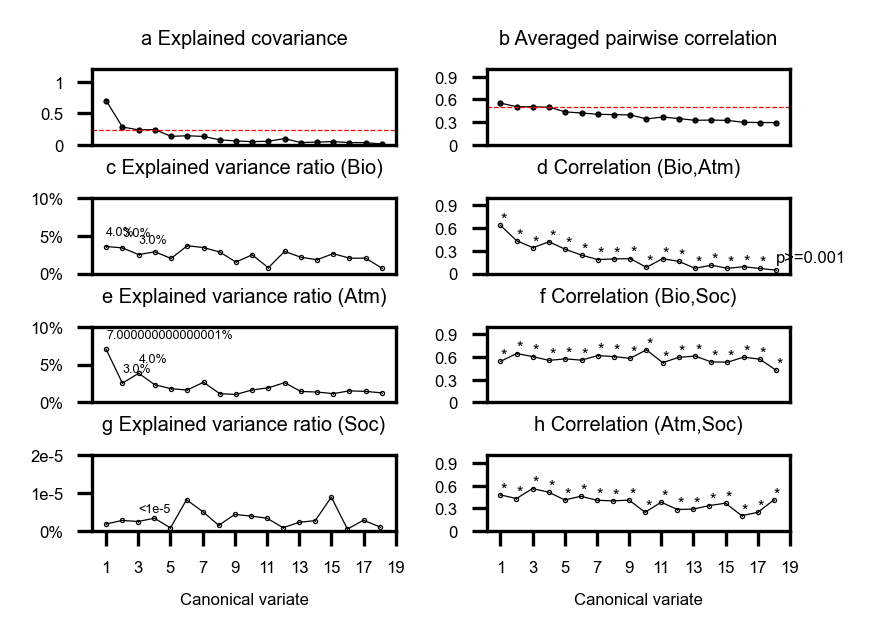

In [12]:
################################### CCA
domain = [bio_var,atm_var,sio_var]
X_mc = df_standard[domain[0]]
Y_mc = df_standard[domain[1]]
Z_mc = df_standard[domain[2]]
dim=18
mcca = MCCA(latent_dimensions=dim).fit((X_mc.values, Y_mc.values, Z_mc.values))

########### cauution!!! when re-install cca-zoo package
########### modify this file _base.py
########### in //Net/Groups/wantong/miniconda3/envs/map/lib/python3.10/site-packages/cca_zoo/_base.py
explained_covariance = mcca.explained_covariance_ratio((X_mc.values, Y_mc.values, Z_mc.values))  # average correlation # I modify the code, not confirmed
print('explained_covariance:',explained_covariance)
########### otherwise MCCA cannot output explained_covariance_ratio. 
########### You can either replace your _base.py file in cca packages by the new _base.py in the data folder or skip this subplot

average_pairwise_correlations = mcca.average_pairwise_correlations((X_mc.values, Y_mc.values, Z_mc.values)) # average correlation
print('Correation coefficients:',average_pairwise_correlations)

X_components, Y_components, Z_components = mcca.transform((X_mc.values, Y_mc.values, Z_mc.values))
df_CCA = pd.DataFrame({"CCX1":X_components[:, 0],
                      "CCY1":Y_components[:, 0],
                       "CCZ1":Z_components[:, 0]
                       })

corr = np.zeros((3,dim))*np.nan
p_value = np.zeros((3,dim))*np.nan
for v in range(dim):
        # df_corr[g,v] = df_CCA['CCX1'].corr(df_CCA['CCY1'],method='pearson')
    corr[0,v], p_value[0,v] = stats.pearsonr(X_components[:, v], Y_components[:, v]) # scipy.stats.pearsonr uses an approximation based on Student's t-distribution
    corr[1,v], p_value[1,v] = stats.pearsonr(X_components[:, v], Z_components[:, v])
    corr[2,v], p_value[2,v] = stats.pearsonr(Y_components[:, v], Z_components[:, v])

print(np.round(corr,4),p_value)

var_exp = mcca.explained_variance_ratio((X_mc.values, Y_mc.values, Z_mc.values))
covar_exp = mcca.explained_covariance((X_mc.values, Y_mc.values, Z_mc.values))
print('var_exp:',np.round(var_exp,4))


fig = plt.figure(figsize=(3,2), dpi=300, tight_layout=True)
gs1 = gridspec.GridSpec(4, 2)
gs1.update(wspace=0.3, hspace=0.7) # set the spacing between axes.

ax = fig.add_subplot(gs1[0])
ax.plot(range(0, dim), covar_exp, '-o', c='black', markersize=0.5, linewidth=0.3)
ax.set_title('a Explained covariance')
ax.set_ylim(0,1.2)
ax.set_yticks([0,0.5,1])
ax.set_yticklabels(['0','0.5','1'])
ax.set_xticks([])
ax.set_xticklabels([])
ax.axhline(y=covar_exp[2], color='red', ls='--', linewidth=0.3)

ax = fig.add_subplot(gs1[1])
ax.plot(range(0, dim), average_pairwise_correlations, '-o', c='black', markersize=0.5, linewidth=0.3)
ax.set_title('b Averaged pairwise correlation')
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_ylim(0,1)
ax.set_yticks([0, 0.3, 0.6, 0.9])
ax.set_yticklabels(['0', '0.3', '0.6', '0.9'])
ax.axhline(y=average_pairwise_correlations[2], color='red', ls='--', linewidth=0.3)

for g in range(3):
    ax = fig.add_subplot(gs1[2+g*2])
    ax.plot(range(0,dim), var_exp[g][:], '-o', c='black', markersize=0.3, linewidth=0.3)
    ax.set_title(['c ','e ','g '][g] + 'Explained variance ratio' + ' ('+['Bio','Atm','Soc'][g] + ')')
    ax.set_ylim(0, 0.08)
    ax.set_yticks([0, 0.05, 0.1])
    ax.set_yticklabels(['0%', '5%', '10%'])
    if g==2:
        ax.set_ylim(0, 0.00002)
        ax.set_yticks([0, 0.00001, 0.00002])
        ax.set_yticklabels(['0%', '1e-5', '2e-5'])
            
    if g==2:
        ax.text(d, 0.000005, '<1e-5', color='black', fontsize=3)
    else:         
        for d in range(3):
            ax.text(d, var_exp[g][d]+0.015, str(np.round(var_exp[g][d],2)*100)+'%', color='black', fontsize=3)

    if g<2:
        ax.set_xticklabels([])
        ax.set_xticks([])
    else:
        ax.set_xlabel('Canonical variate')
        ax.set_xticks(np.arange(0,20,2))
        ax.set_xticklabels(np.arange(1,21,2))

    ax = fig.add_subplot(gs1[3+g*2])
    ax.set_title(['d ','f ','h '][g] + 'Correlation' + ' ('+['Bio,Atm','Bio,Soc','Atm,Soc'][g] + ')')
    ax.plot(range(0, dim), corr[g][:], '-o', c='black', markersize=0.3, linewidth=0.3)
    ax.set_ylim(0, 1)
    ax.set_yticks([0, 0.3, 0.6, 0.9])
    ax.set_yticklabels(['0', '0.3', '0.6', '0.9'])

    for v in range(dim):
        if p_value[g][v]>=0.001:
            ax.text(v + 0.001, corr[g][v] + 0.1, 'p>=0.001', color='black', fontsize=4)
        else:
            ax.text(v, corr[g][v] + 0.015, '*', color='black', fontsize=4)


    if g<2:
        ax.set_xticklabels([])
        ax.set_xticks([])
    else:
        ax.set_xlabel('Canonical variate')
        ax.set_xticks(np.arange(0,20,2))
        ax.set_xticklabels(np.arange(1,21,2))



# Plot the similarity between a setup of removing 1/5 variables in generating CCA components and the reference setup

r2: [0.49787897 0.47416987 0.45387866 0.4154193  0.38617746 0.37405645
 0.37046209 0.34744558 0.32054173 0.32898228]
100
[0.66500505 0.72432688 0.88924839 0.70912691 0.50960995 0.78352761
 0.80137406 0.59162946 0.79266126 0.94358907 0.73394999 0.91234579
 0.61445628 0.71027527 0.75961545 0.9708211  0.83057963 0.75982021
 0.84800115 0.62263318 0.75425812 0.79901732 0.92812131 0.63033118
 0.62966779 0.71810437 0.87933973 0.67824138 0.79255815 0.54131231
 0.69389765 0.7170481  0.65636713 0.75475589 0.56858338 0.5353371
 0.93280166 0.57624305 0.98617405 0.72536358 0.76802455 0.92641125
 0.75412862 0.70751988 0.92990573 0.74864132 0.75685635 0.88906793
 0.83274603 0.75812491 0.62373107 0.5772521  0.72564705 0.62251832
 0.33810893 0.72746314 0.58013904 0.72227637 0.88570709 0.48458292
 0.59559652 0.87706102 0.83309739 0.47932872 0.75470896 0.76037373
 0.96697773 0.58104055 0.59862509 0.87578764 0.8070427  0.92740219
 0.95139163 0.72748324 0.69364276 0.83542379 0.7585512  0.75321912
 0.625211

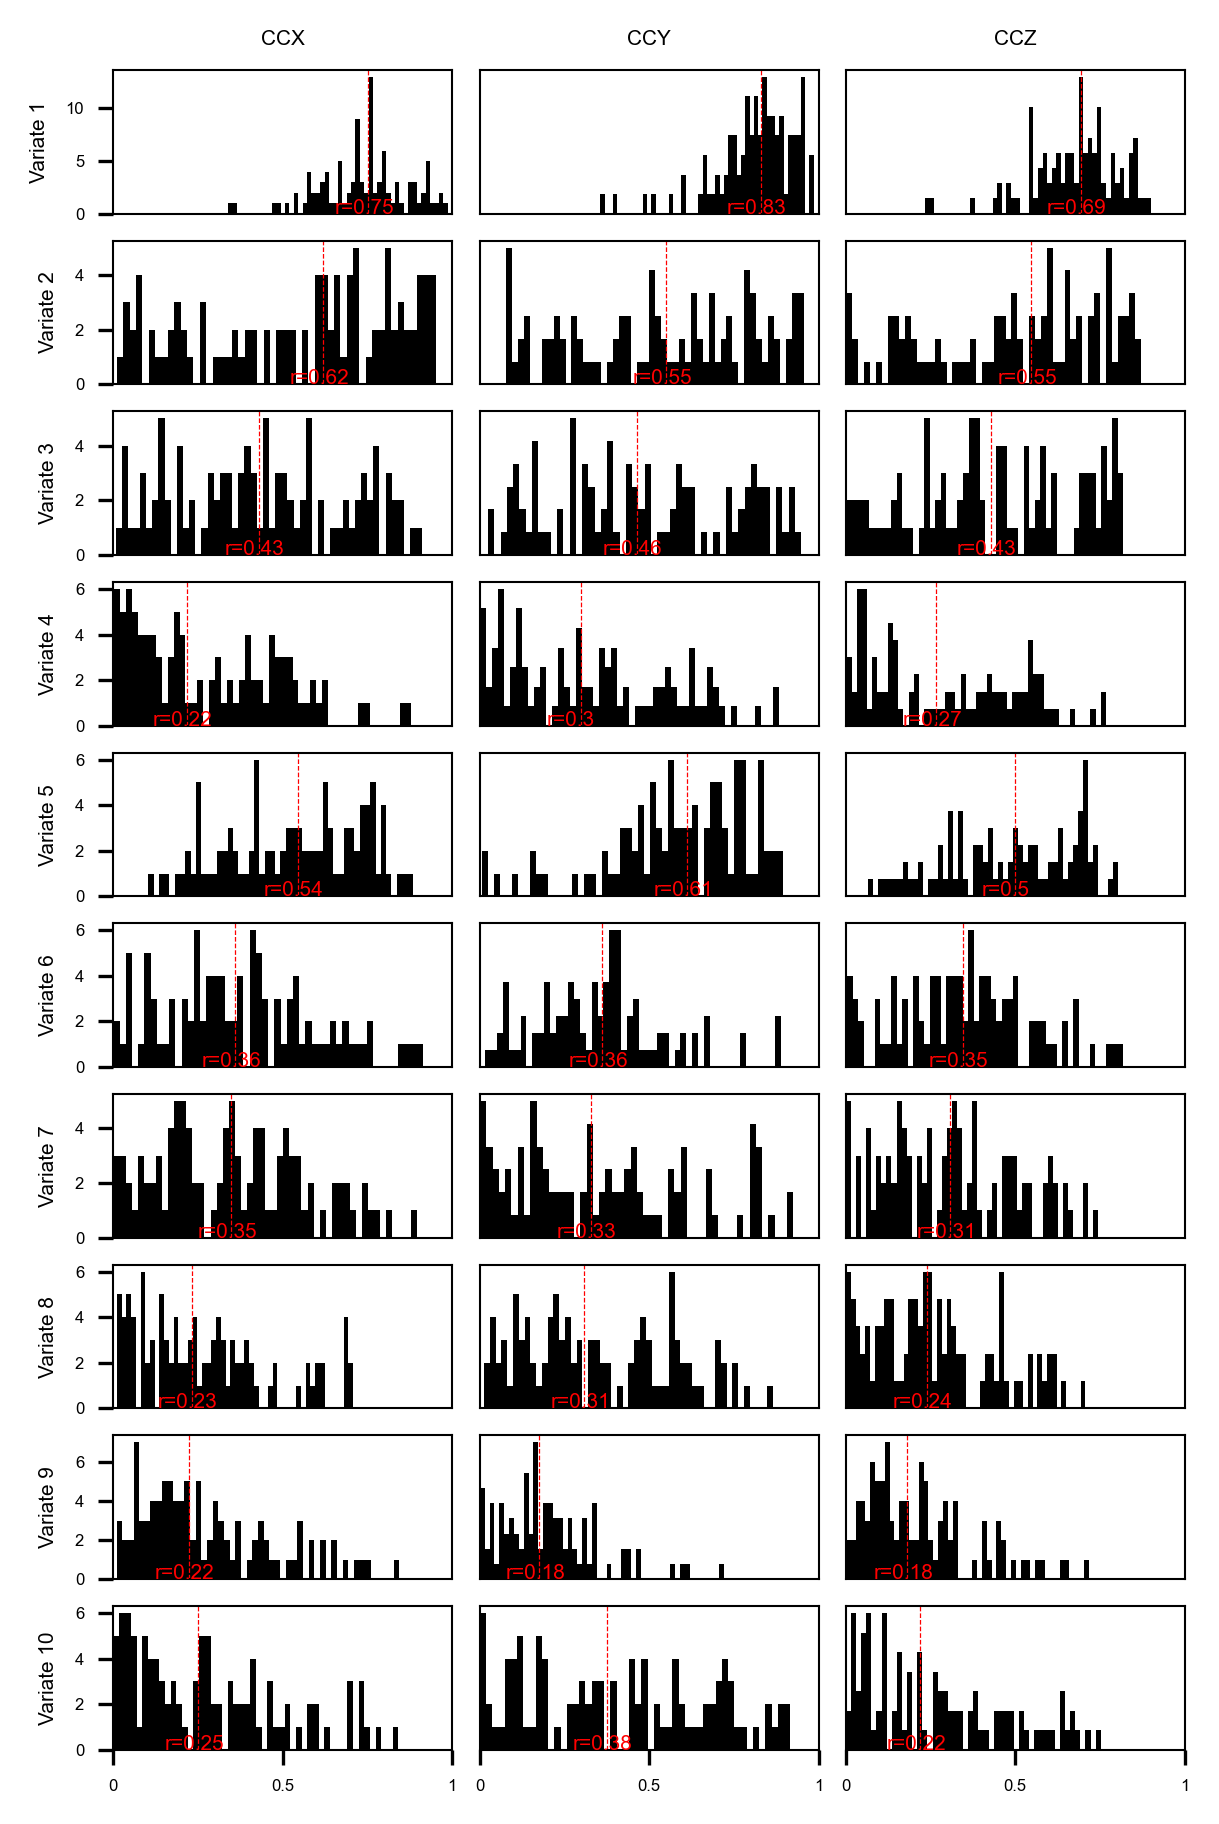

<Figure size 640x480 with 0 Axes>

In [14]:
###################################### CCA robustness
domain = [bio_var,atm_var,sio_var]
X_mc = df_standard[domain[0]]
Y_mc = df_standard[domain[1]]
Z_mc = df_standard[domain[2]]
dim=10
mcca = MCCA(latent_dimensions=dim).fit((X_mc.values, Y_mc.values, Z_mc.values))
X_components_ref, Y_components_ref, Z_components_ref = mcca.transform((X_mc.values, Y_mc.values, Z_mc.values))
average_pairwise_correlations = mcca.average_pairwise_correlations((X_mc.values, Y_mc.values, Z_mc.values)) # average correlation
print('r2:',average_pairwise_correlations)

pvalue_sum = np.zeros(dim)
pvalue_num = np.zeros(dim)
n = 100 # you can adjust it to 100 to get a quick run
cor = np.zeros((n, 3, dim)) * np.nan
sum = 0
for permu in range(n):
    if sum < n:
        bio_var1 = ['albedo', 'albedo_times_ssrd',
                    # 'ET_gleam', 'ET_era5',
                    'sm', 'tws', 'ndwi',
                    'LST_divide_t2m',
                    'ndvi', 'nirv', 'sif_gosif',
                    'VOD_day', 'VOD_night', 'VOD_ratio']
        atm_var1 = ['PET', 'ssrd', 'tp', 'rh', 't2m', 't2m_min_min', 't2m_max_max', 't2m_min_mean', 't2m_max_mean', 'cloud', 'PEI_90']

        bio_var = []
        atm_var = []
        column_name = ['', '_weightedbyPOP']
        for multi_var in range(len(column_name)):
            bio_var.append([s + column_name[multi_var] for s in bio_var1])
            atm_var.append([s + column_name[multi_var] for s in atm_var1])
        bio_var = [item for sublist in bio_var for item in sublist]
        atm_var = [item for sublist in atm_var for item in sublist]
        atm_var = [item for item in atm_var if item not in ['t2m_min_min_weightedbyPOP', 't2m_max_max_weightedbyPOP']]

        sio_gapfilled = pd.read_csv(data_path('data/WDI_2003_2022_gapfilled_mask0.7.csv'))
        sio_var = sio_gapfilled.drop(columns=['Country Code','year']).columns.values.tolist()

        remove_1times3 = np.random.choice(bio_var + atm_var + sio_var, replace=False,
                                          size=int(len(bio_var + atm_var + sio_var) * 1 / 5))
        bio_var = [ele for ele in bio_var if ele not in remove_1times3]
        atm_var = [ele for ele in atm_var if ele not in remove_1times3]
        sio_var = [ele for ele in sio_var if ele not in remove_1times3]

        domain = [bio_var, atm_var, sio_var]
        X_mc = df_standard[domain[0]]
        Y_mc = df_standard[domain[1]]
        Z_mc = df_standard[domain[2]]
        if len(bio_var) > 0 and len(atm_var) > 0 and len(sio_var) > 0:
            if min(len(bio_var), len(atm_var), len(sio_var)) > dim:
                dim_min = dim
            else:
                dim_min = min(len(bio_var), len(atm_var), len(sio_var))
            mcca = MCCA(latent_dimensions=dim_min).fit( (X_mc.values, Y_mc.values, Z_mc.values))
            X_components_test, Y_components_test, Z_components_test = mcca.transform(
                (X_mc.values, Y_mc.values, Z_mc.values))

            for comp in range(dim_min):
                r1, p = stats.pearsonr(X_components_ref[:, comp], X_components_test[:, comp])
                r2, p = stats.pearsonr(Y_components_ref[:, comp], Y_components_test[:, comp])
                r3, p = stats.pearsonr(Z_components_ref[:, comp], Z_components_test[:, comp])
                cor[sum, 0, comp] = np.abs(r1)
                cor[sum, 1, comp] = np.abs(r2)
                cor[sum, 2, comp] = np.abs(r3)

            sum = sum + 1

print(sum)


fig = plt.figure(figsize=(4, 6), dpi=300, tight_layout=True)
for domain in range(3):
    for comp in range(10): ### plot dim 1-10
        ax = fig.add_subplot(dim, 3, 1 + comp * 3 + domain)
        print(cor[:, domain, comp])
        ax.hist(cor[:, domain, comp], 50, color='black')
        ax.axvline(x=np.nanpercentile(cor[:, domain, comp], 50), color='red', ls='--')
        ax.text(np.nanpercentile(cor[:, domain, comp], 50) - 0.1, 0,
                s='r=' + str(np.round(np.nanpercentile(cor[:, domain, comp], 50), 2)), color='r',fontsize=5)
        ax.set_xlim(0, 1)
        # ax.set_ylim(0, 3000)
        ax.set_xticks([0, 0.5, 1])
        # ax.set_yticks([0, 1500, 3000])
        ax.set_xticklabels(['0', '0.5', '1'])
        ax.set_ylabel('Variate '+str(comp+1),fontsize=5)

        if comp == 0:
            # ax.set_title(['CCX', 'CCY', 'CCZ'][domain] + str(comp) + ', N=' + str(np.sum(~np.isnan(cor[:, domain, comp]))))
            ax.set_title(['CCX', 'CCY', 'CCZ'][domain],fontsize=5)

        if domain != 0:
            plt.gca().axes.get_yaxis().set_visible(False)

        if comp!=9:
            plt.gca().axes.get_xaxis().set_visible(False)

        plt.setp(ax.spines.values(), lw=0.5)

plt.show()
# plt.savefig(data_path('figure/sfig_similarity_dim10_remove20%_100.jpg'), bbox_inches='tight')

